## Query 4: Distribution of Departments across Contacts

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

RANDOM_STATE = 7

In [2]:
contact = pd.read_csv('./Contact-Grid view.csv')
contact = contact.dropna(subset=['Adopter', 'Requestor'])
contact.head()

,PID,Fname,Lname,Works_At,State,Country,Title,Adopter,Requestor
0,1.0,Ambrosius,Mitchell,"Amrita School of Engineering, Coimbatore, India",NaN,India,Office Manager,True,False
1,2.0,Marius,Flores,Berkeley City College,California,United States,Assistant Provost,True,False
2,3.0,Tulio,Perez,Boise State University,Idaho,United States,Lecturer,False,True
3,4.0,John,Huang,BRAC University,Dhaka,Bangladesh,Associate Professor,False,True
4,5.0,Leah,Adamson,Brigham Young University,Utah,United States,Associate Liaison to Internal Technology,False,True


In [3]:
departments = ['Data Science','Mathematics', 'Computer Science', 'Statistics', 'History', 'Biology']
np.random.seed(RANDOM_STATE)
contact_depts = np.random.choice(a=departments, size=len(contact),p=[0.40, 0.10, 0.25, 0.20, 0.01, 0.04])

In [4]:
contact['Department'] = contact_depts

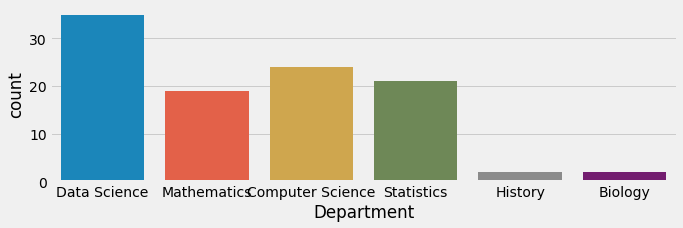

In [5]:
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(10,3))
sns.countplot(x='Department', data=contact, order=departments);

### Random Forests to Predict Future Departments

First, change all categorical columns accordingly to the right dtypes.

In [6]:
contact['Works_At'] = contact['Works_At'].astype('category').cat.codes
contact['State'] = contact['State'].astype('category').cat.codes
contact['Country'] = contact['Country'].astype('category').cat.codes
contact['Title'] = contact['Title'].astype('category').cat.codes
contact['Department'] = contact['Department'].astype('category')
contact.dtypes

PID            float64
Fname           object
Lname           object
Works_At          int8
State             int8
Country           int8
Title             int8
Adopter         object
Requestor       object
Department    category
dtype: object

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(contact.iloc[:, [3,5,6,7,8]], contact.iloc[:, -1], test_size=0.2, random_state=RANDOM_STATE)

In [8]:
pd.isna(X_train).sum()

Works_At     0
Country      0
Title        0
Adopter      0
Requestor    0
dtype: int64

In [9]:
regressor = RandomForestClassifier(n_estimators=20, random_state=RANDOM_STATE)
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


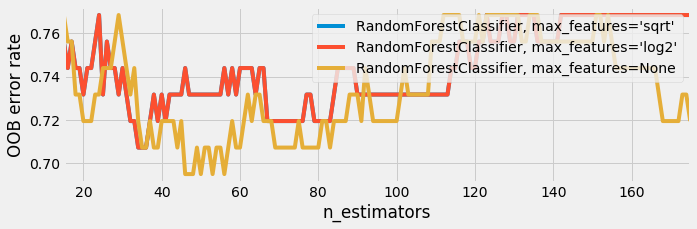

In [11]:
from collections import OrderedDict
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.subplots(figsize=(10,3))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right");